In [1]:
import numpy as np
import scipy as sp
import seaborn as sn
import matplotlib.pylab as pl
%matplotlib inline

import os 
os.chdir('../src/')

from EDFOperator import EDFOperator
from HDFEyeOperator import HDFEyeOperator
from EyeSignalOperator import EyeSignalOperator



os.chdir('../test/')

/Users/knapen/anaconda2/envs/analysis/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/knapen/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.linalg.calc_lwork` is deprecated!

calc_lwork was an internal module in Scipy and has been removed.

Several functions in scipy.linalg.lapack have *_lwork variants
that perform the lwork calculation (from Scipy >= 0.15.0), or
allow passing in LWORK=-1 argument to perform the computation.


  warnings.warn(depdoc, DeprecationWarning)


In [2]:
edf_file = 'tk_1_2014-10-06_16.44.11.edf'

low_pass_pupil_f, high_pass_pupil_f = 8.0, 0.02
alias = 'test_1'

# initialize the hdfeyeoperator
ho = HDFEyeOperator('test.h5')
# insert the edf file contents only when the h5 is not present.
if not os.path.isfile('test.h5'):
    ho.add_edf_file(edf_file)
    ho.edf_message_data_to_hdf(alias = alias)
    ho.edf_gaze_data_to_hdf(alias = alias, pupil_hp = high_pass_pupil_f, pupil_lp = low_pass_pupil_f)

In [3]:
# downsample for plotting
downsample_rate = 10

# load times per session:
trial_times = ho.read_session_data(alias, 'trials')
trial_phase_times = ho.read_session_data(alias, 'trial_phases')

# check at what timestamps the recording started:
session_start_EL_time = np.array( trial_phase_times[np.array(trial_phase_times['trial_phase_index'] == 1) * np.array(trial_phase_times['trial_phase_trial'] == 0)]['trial_phase_EL_timestamp'] )[0]
session_stop_EL_time = np.array(trial_times['trial_end_EL_timestamp'])[-1]

# and, find some aspects of the recording such as sample rate and recorded eye
sample_rate = ho.sample_rate_during_period([session_start_EL_time, session_stop_EL_time], alias)
eye = ho.eye_during_period([session_start_EL_time, session_stop_EL_time], alias)
if len(eye) > 0:
    eye = ['L','R'][0]

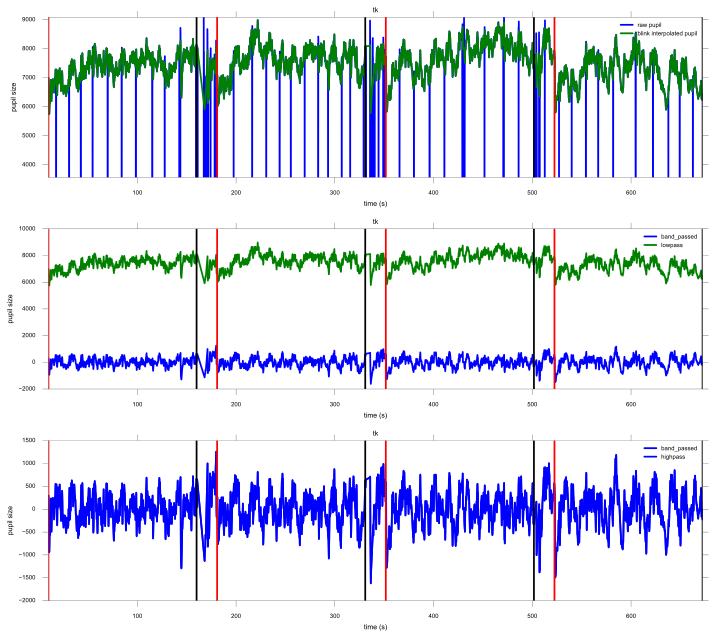

In [4]:
#
# plot some of the pupil signal's processing steps
#

pupil_raw = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil', requested_eye = eye))
pupil_int = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_int', requested_eye = eye))

pupil_bp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_bp', requested_eye = eye))
pupil_lp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_lp', requested_eye = eye))
pupil_hp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_hp', requested_eye = eye))

x = sp.signal.decimate(np.arange(len(pupil_raw)) / float(sample_rate), downsample_rate, 1)
pup_raw_dec = sp.signal.decimate(pupil_raw, downsample_rate, 1)
pup_int_dec = sp.signal.decimate(pupil_int, downsample_rate, 1)

pupil_bp_dec = sp.signal.decimate(pupil_bp, downsample_rate, 1)
pupil_lp_dec = sp.signal.decimate(pupil_lp, downsample_rate, 1)
pupil_hp_dec = sp.signal.decimate(pupil_hp, downsample_rate, 1)

# plot interpolated pupil:
fig = pl.figure(figsize = (10,9))
s = fig.add_subplot(311)
pl.plot(x, pup_raw_dec, 'b'); pl.plot(x, pup_int_dec, 'g')
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['raw pupil', 'blink interpolated pupil'])
s.set_title('tk')

ymin = pupil_raw.min(); ymax = pupil_raw.max()
tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
for i in range(tps[0].shape[0]):
    pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'r')
    pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
s.set_xlim(xmin = tps[0][0] / float(sample_rate), xmax = tps[1][-1] / float(sample_rate))

s = fig.add_subplot(312)
pl.plot(x, pupil_bp_dec, 'b'); pl.plot(x, pupil_lp_dec, 'g');
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['band_passed', 'lowpass'])
s.set_title('tk')

ymin = pupil_raw.min(); ymax = pupil_raw.max()
tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
for i in range(tps[0].shape[0]):
    pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'r')
    pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
# s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
s.set_xlim(xmin = tps[0][0] / float(sample_rate), xmax = tps[1][-1] / float(sample_rate))

s = fig.add_subplot(313)
pl.plot(x, pupil_bp_dec, 'b'); pl.plot(x, pupil_hp_dec, 'b');
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['band_passed', 'highpass'])
s.set_title('tk')

ymin = pupil_raw.min(); ymax = pupil_raw.max()
tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
for i in range(tps[0].shape[0]):
    pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'r')
    pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
# s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
s.set_xlim(xmin = tps[0][0] / float(sample_rate), xmax = tps[1][-1] / float(sample_rate))

pl.tight_layout()
